# Разведывательный анализ данных учащихся

## Цель проекта:
Отследить **влияние условий жизни** учащихся в возрасте от 15 до 22 лет **на их успеваемость по математике**, что позволит на ранней стадии выявлять студентов, находящихся в группе риска.

## Задачи проекта:
1. Провести **разведывательный анализ данных (EDA)**:
    - _проверить качество данных_ и очистить их при необходимости;
    - _сформулировать предположения_ для дальнейшего построения модели;
    - _определиться с параметрами модели_, оказывающими влияние на целевой показатель (успеваемость по математике).
2. Построить модель, предсказывающую результаты госэкзамена по математике для каждого ученика школы.

В рамках данного подпроекта решалась только **первая задача**. 

## Первичный осмотр данных

In [59]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import math 

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import ttest_ind

import mod_eda # импортируем модуль с созданными функциями проведения EDA

# Настроим вывод графиков и таблиц
sns.set()

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок

In [60]:
# Загрузим исходный датасет и рассмотрим его
stud = pd.read_csv('stud_math.csv')
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Первичный осмотр данных позволяет сделать вывод о том, что только *первые 3 колонки без пропусков*: "school", "sex", "age". 

В распоряжении имеются *30* колонок, из них *13* - **условно числовых** (хотя истинно **числовых** только *4*: "age", "absences", "score" и "studytime, granular", остальные **ранговые**), *17* - **категориальных** (*8* из них потенциально можно превратить в бинарный тип).  

Также первичный осмотр данных показал, что часть колонок названы с большой буквы (с целью отделения одного слова от другого). Есть также одна колонка "studytime, granular" имеющая название, написанное через запятую. 

Приведём колонки к стилю написания с маленькой буквы с отделением слов подчёркиванием.

In [61]:
stud.columns = ['school', 'sex', 'age', 'adress', 'famsize', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health', 'absences', 'score']
display(stud.head(10))

,school,sex,age,adress,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### Описание колонок:
1 **school** — аббревиатура школы, в которой учится ученик;

2 **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

3 **age** — возраст ученика (от **15** до **22**);

4 **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

5 **famsize** — размер семьи(**'LE3'** <= 3, **'GT3'** >3);

6 **p_status** — статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно);

7 **m_edu** — образование матери (**0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее);

8 **f_edu** — образование отца (**0** - нет, **1** - 4 класса, **2** - 5-9 классы, 
    **3** - среднее специальное или 11 классов, **4** - высшее);

9 **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

10 **f_job** — работа отца (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **'services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

11 **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое);

12 **guardian** — опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое);

13 **traveltime** — время в пути до школы (**1** - <15 мин., **2** - 15-30 мин., 
    **3** - 30-60 мин., **4** - >60 мин.);

14 **studytime** — время на учёбу помимо школы в неделю (**1** - <2 часов, **2** - 2-5 часов, 
    **3** - 5-10 часов, **4** - >10 часов);

15 **failures** — количество внеучебных неудач (**n**, если 1<=n<3, иначе **4**);

16 **schoolsup** — дополнительная образовательная поддержка (**yes** или **no**);

17 **famsup** — семейная образовательная поддержка (**yes** или **no**);

18 **paid** — дополнительные платные занятия по математике (**yes** или **no**);

19 **activities** — дополнительные внеучебные занятия (**yes** или **no**);

20 **nursery** — посещал детский сад (**yes** или **no**);

**studytime_granular** - неизвестная колонка, необходимо понять, с чем она коррелирует

21 **higher** — хочет получить высшее образование (**yes** или **no**);

22 **internet** — наличие интернета дома (**yes** или **no**);

23 **romantic** — в романтических отношениях (**yes** или **no**);

24 **famrel** — семейные отношения (от **1** - очень плохо до **5** - очень хорошо);

25 **freetime** — свободное время после школы (от **1** - очень мало до **5** - очень мого);

26 **goout** — проведение времени с друзьями (от **1** - очень мало до **5** - очень много);

27 **health** — текущее состояние здоровья (от **1** - очень плохо до **5** - очень хорошо);

28 **absences** — количество пропущенных занятий;

29 **score** — баллы по госэкзамену по математике (целевой параметр).


## Первичный анализ данных в столбцах

### school
Аббревиатура школы, в которой учится ученик.

,total,proportion
GP,349,0.883544
MS,46,0.116456


None-значения отсутствуют. Пробельные пропуски отсутствуют.
Общий размер выборки студентов: 395


(array([0, 1]), <a list of 2 Text xticklabel objects>)

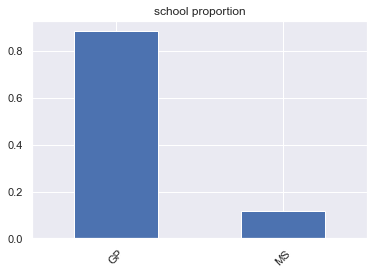

In [62]:
# Интересующая колонка
column = 'school'

# Оценим состав данной колонки
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

#Имеются ли None-элементы или пробельные пропуски
print(mod_eda.find_nulls(stud[column])[0])

# Определим размер выборки студентов
stud_count_total = stud[column].value_counts().sum()
print('Общий размер выборки студентов:', stud_count_total)

#Построим распределение
pd.DataFrame(stud[column].value_counts(normalize=True)).plot(kind='bar',
                                                               grid= True,
                                                               title=column + " proportion",
                                                               legend=False) 
plt.xticks(rotation=45) # Учебный комментарий: пробелы вокруг "=" для именнованного аргумента не ставятся (pep-8)

Пропуски в данном столбце отсутствуют. Около *88%* студентов выборки (общим размером *395* человек) обучаются в школе *"GP"*.  

### sex
Пол ученика: 'F' - женский, 'M' - мужской

,total,proportion
F,208,0.526582
M,187,0.473418


None-значения отсутствуют. Пробельные пропуски отсутствуют.


(array([0, 1]), <a list of 2 Text xticklabel objects>)

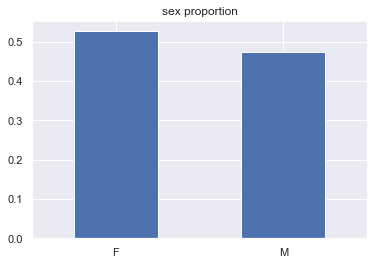

In [63]:
# Интересующая колонка
column = 'sex'

# Оценим состав данной колонки
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

#Имеются ли None-элементы или пробельные пропуски
print(mod_eda.find_nulls(stud[column])[0])

#Построим распределение
pd.DataFrame(stud[column].value_counts(normalize=True)).plot(kind='bar',
                                                               grid= True,
                                                               title=column + " proportion",
                                                               legend=False)
plt.xticks(rotation = 0) 

В данном столбце пропусков нет. Имеется небольшой перевес, порядка 5% в пользу количества девочек в выборке.

### age
Возраст ученика (от 15 до 22)

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

None-значения отсутствуют. Пробельные пропуски отсутствуют.


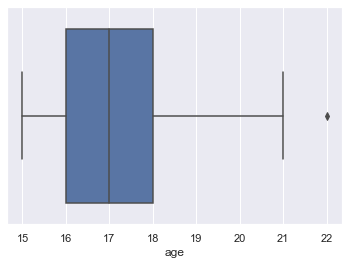

In [64]:
# Интересующая колонка
column = 'age'

# Статистическое описание колонки
display(stud[column].describe())

#Имеются ли None-элементы или пробельные пропуски
print(mod_eda.find_nulls(stud[column])[0])

#Построим boxplot
sns.boxplot(stud[column])

Присутствуют выбросы, вычислим границы выбросов.

,outliers_count
22,1


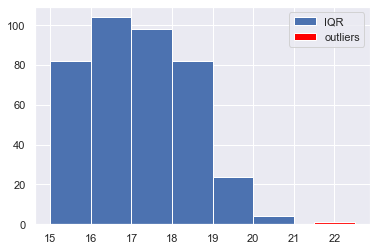

In [65]:
# Определим границы выбросов, и выведем данные, соответствующие этому диапазону в гистограмму
boards = mod_eda.get_boards(stud[column])

# Выведем значение и количество выбросов
display(pd.DataFrame({'outliers_count': stud[(stud[column] > boards[1])|
                        (stud[column] < boards[0])][column].value_counts()}))

# Посмотрим распределение признака
stud[stud[column].between(boards[0], boards[1])][column].hist(bins=6, label = 'IQR') # Значения без выбросов
stud[(stud[column] > boards[1])|(stud[column] < boards[0])][column].hist(bins = 1, color = 'red', label = 'outliers') # Выбросы

plt.legend()

В данном столбце отсутствуют пропуски. Возраст студентов имеет близкое к нормальному распределение. Имеется один выброс - 22 года

### adress
Тип адреса ученика: **'U'** - городской, **'R'** - за городом.

,total,proportion
U,295,0.780423
R,83,0.219577


17 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 4.3%


(array([0, 1]), <a list of 2 Text xticklabel objects>)

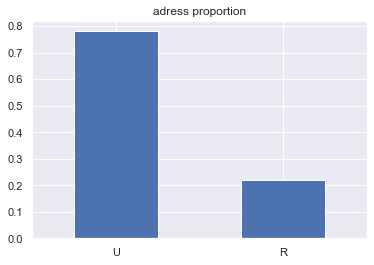

In [66]:
# Интересующая колонка
column = 'adress'

# Оценим состав данной колонки
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Имеются ли None-элементы или пробельные пропуски
nulls_list = mod_eda.find_nulls(stud[column])
print(nulls_list[0])

# Оценим процентное содержание пропусков
nulls_sum = nulls_list[1] + nulls_list[2]

if nulls_sum > 0:
    print(f'Доля пропусков от объёма выборки: {round(nulls_sum/stud_count_total*100, 1)}%')

# Построим распределение
pd.DataFrame(stud[column].value_counts(normalize=True)).plot(kind='bar',
                                                               grid= True,
                                                               title=column + " proportion",
                                                               legend=False)
plt.xticks(rotation = 0) 

Проанализируем варианты заполнения пропусков.

Метод **"приписывания"** подразумевает наличие взаимосвязи значений рассматриваемого столбца с другими, на основе которой можно предположить, какое значение могло быть вместо пропуска

In [67]:
#Сопоставим жителей за городом/городских с размером семьи
display(pd.DataFrame({'R': stud[stud['adress'] == 'R']['famsize'].value_counts(normalize=True),
                      'U': stud[stud['adress'] == 'U']['famsize'].value_counts(normalize=True)}))

,R,U
GT3,0.763158,0.699275
LE3,0.236842,0.300725


Колонка **'famsize'** не подходит для реализации рассматриваемого метода заполнения пропусков, так как пропорция слабо отличается при разном типе адреса

In [68]:
temp = stud.copy(deep=True) # Копирование датафрейма без зависимости
#Временно, для грубой оценки зависимости, приведём столбец "adress" к числовому виду
temp['adress'] = temp['adress'].apply(lambda x: 1 if str(x) == 'U' else 0 if str(x) == 'R' else None)
temp.corr()['adress']

age                  -0.147902
adress                1.000000
m_edu                 0.153189
f_edu                 0.065295
traveltime           -0.285782
studytime            -0.045182
failures             -0.101835
studytime_granular    0.045182
famrel               -0.017216
freetime              0.055708
goout                 0.063285
health               -0.049985
absences              0.025661
score                 0.120067
Name: adress, dtype: float64

Анализ показал, что имеется связь между **"adress" и "traveltime"** (типом адреса ученика и временем, затрачиваемым на дорогу). Предполагается, что при большом времени в пути ученик живёт за городом. 

In [69]:
#Сопоставим жителей за городом/города с временем в дороге
display(pd.DataFrame({'R': stud[stud['adress'] == 'R']['traveltime'].value_counts(normalize=True),
                      'U': stud[stud['adress'] == 'U']['traveltime'].value_counts(normalize=True)}))

,R,U
1.0,0.447368,0.722022
2.0,0.342105,0.234657
3.0,0.157895,0.032491
4.0,0.052632,0.010830


На основании полученного распределения, положим, что значению **1** параметра "traveltime" (меньше 15 минут) соответствует **городской** тип адреса, а остальным - **загородный**. К городскому также отнесём вариант None в параметре "traveltime".

Данное допущение было принято на основе сопоставления распределения числа пропущенных значений по продолжительности пути в школу (см. ниже) с той пропорцией, что была обнаружена ранее, между городскими и загородными жителями.

In [70]:
#Распределение пропусков в изучаемом столбце по продолжительности пути в школу
display(pd.DataFrame({'total': stud[stud['adress'].isna()]['traveltime'].value_counts(), 
                      'proportion': stud[stud['adress'].isna()]['traveltime'].value_counts(normalize=True)}))

,total,proportion
1.0,8,0.571429
2.0,5,0.357143
3.0,1,0.071429


In [93]:
#Функция присвоения типа адреса в соответствии с вышеизложенными рассуждениями
def get_adress(row):
    if pd.isnull(row['adress']):
        if row['traveltime'] == 1 or row['traveltime'] == None:
            return 'U'
        else: 
            return 'R'
    return row['adress']

stud['adress'] = stud.apply(get_adress, axis = 1)
stud['adress'].isna().value_counts()

False    395
Name: adress, dtype: int64

In [94]:
# Оценим новый состав данной колонки
display(pd.DataFrame({'total': stud['adress'].value_counts(), 
                      'proportion': stud['adress'].value_counts(normalize=True)}))

,total,proportion
U,303,0.767089
R,92,0.232911


Таким образом, **17** пропущенных значений колонки **adress** были заполнены методом **приписывания**, то есть с учётом данных в других колонках. 

Около 77% учеников живёт в городе.

### famsize
Размер семьи: 'LE3' <= 3, 'GT3' >3

,total,proportion
GT3,261,0.709239
LE3,107,0.290761


27 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 6.8%


(array([0, 1]), <a list of 2 Text xticklabel objects>)

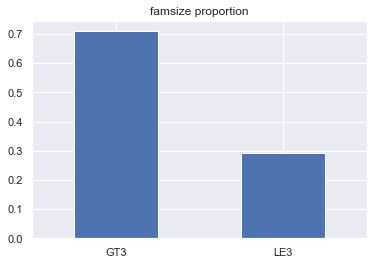

In [97]:
# Интересующая колонка
column = 'famsize'

# Оценим состав данной колонки
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Имеются ли None-элементы или пробельные пропуски
nulls_list = mod_eda.find_nulls(stud[column])
print(nulls_list[0])

# Оценим процентное содержание пропусков
nulls_sum = nulls_list[1] + nulls_list[2]

if nulls_sum > 0:
    print(f'Доля пропусков от объёма выборки: {round(nulls_sum/stud_count_total*100, 1)}%')

# Построим распределение
pd.DataFrame(stud[column].value_counts(normalize=True)).plot(kind='bar',
                                                               grid= True,
                                                               title=column + " proportion",
                                                               legend=False)
plt.xticks(rotation = 0) 

In [98]:
#Сопоставим размер семьи с совместным/раздельным проживанием родителей
display(pd.DataFrame({'LE3': stud[stud['famsize'] == 'LE3']['p_status'].value_counts(normalize=True),
                      'GT3': stud[stud['famsize'] == 'GT3']['p_status'].value_counts(normalize=True)}))

,LE3,GT3
T,0.861702,0.914163
A,0.138298,0.085837
